In [2]:
# %matplotlib qt5
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from utils import *

In [3]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@(x)+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)

def cal_radius_eigv_intersection(x, J,g,gamma,ce,ci,N,ALPHAE,ALPHAI):
    tau = x[0]
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
            
    ### theoretical prediction of the eigenvalues

    org_k = J*N*(ALPHAE-g*ALPHAI)/2.0

    eigvchn_theo0 = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau))
    eigvchn_theo1 = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau))
    
    return eigvchn_theo1-radius_theo

### copmpute the intersection 
from scipy.optimize import fsolve

In [4]:
ntau   = 10#21#
trials = 30+6#6
tau_series = np.linspace(0,0.225,ntau)# np.linspace(0.25,0.4,ntau)#
tau_series

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225])

#### Equivalent Gaussian Approximation

In [5]:
### define the network parameters of the adjacency matrix
nn = [50,100,150,250,750,800,1200]
g, gamma = 6.0, 1/4.0#
NE = nn[-1] ## network size = 1500
NI = int(gamma*NE)
N  = NE+NI
ALPHAE, ALPHAI = NE/N, NI/N
c = 0.2 ### sparsity, identical for excitatory and inhibitory neuron populations
KE, KI = int(c*NE), int(c*NI) ### fixed out-degree
J = 1/np.sqrt(1500)*0.5  ### TODO: make sure this scalar with David&Stefano's paper
print('number of connected E/I neurons:',KE,KI)
print('non-zero J:',J)
ji,je = g*J,J 

### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 
print('lambda0:',lambda0)
print('ge,gi:',ge,gi)
print('JE,JI:',JE,JI)

number of connected E/I neurons: 240 60
non-zero J: 0.012909944487358056
lambda0: -1.5491933384829668
ge,gi: 0.2 1.2000000000000002
JE,JI: 3.0983866769659336 4.6475800154489


In [6]:
ntau   = 10#21#
trials = 30+6#6
tau_series = np.linspace(0,0.225,ntau)# np.linspace(0.25,0.4,ntau)#
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### normalization for left and right eigenvectors 
norms_for_lvec, norms_for_rvec = np.zeros((trials,ntau+1,2)), np.zeros((trials,ntau+1,2))
### also have the reconstructed left and right eigenvectors 
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
htau = tau_series[1]-tau_series[0]
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
### compute the square of the random connectivity 
Z2E = N*J**2*hat_sigmae**2*tau_series*ALPHAE-N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE+N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E, DeltaZ2I = Z2E[1]-Z2E[0],Z2I[1]-Z2I[0] ### for practical use
DeltaZ2 = np.zeros((N,N))
DeltaZ2[:,:NE], DeltaZ2[:,NE:] = DeltaZ2E, DeltaZ2I

### E population and I population separately
Z2E_E, Z2I_E = N*J**2*hat_sigmae**2*tau_series*ALPHAE, -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2E_I, Z2I_I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE, N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E_E, DeltaZ2I_E = Z2E_E[1]-Z2E_E[0],Z2I_E[1]-Z2I_E[0] ### for practical use
DeltaZ2E_I, DeltaZ2I_I = Z2E_I[1]-Z2E_I[0],Z2I_I[1]-Z2I_I[0] ### for practical use
DeltaZ2_E, DeltaZ2_I = np.zeros((N,N)),np.zeros((N,N))
DeltaZ2_E[:,:NE], DeltaZ2_E[:,NE:] = DeltaZ2E_E, DeltaZ2I_E

eigvJ0: (-1.5491933384830117+0j)  theory: -1.5491933384829668


In [7]:
ce, ci = c,c
radius_theo_map = np.zeros(ntau)
for it, tau in enumerate(tau_series):
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
### theoretical prediction of the eigenvalues

org_k = J*N*(ALPHAE-g*ALPHAI)/2.0
eigvchn_theo = np.zeros((ntau,2))
eigvchn_theo[:,0] = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau_series))
eigvchn_theo[:,1] = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau_series))

In [8]:
### if you want to re-run the simulation
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))
firing_rateeq_bulk = np.zeros((trials,ntau,N))
z_pre = np.zeros((N,N))
### recording dynamics
switch,factor = 3,1
### trials random networks and vectors 
xrs   = np.zeros((trials,N,N))
xrecs = np.zeros((trials,N,N))
chnetas = np.zeros((trials,N,6))
for ktrial in range(trials):
    xrs[ktrial,:,:]      = iidGaussian([0,1/np.sqrt(N)],[N,N])
    chnetas[ktrial,:,:]  = iidGaussian([0,1/np.sqrt(N)],[N,6])
    xrecs[ktrial,:,:]    = iidGaussian([0,1/np.sqrt(N)],[N,N])
    ### zscore
    xrs_   = stats.zscore(xrs[ktrial,:,:].flatten())
    xrs_  = xrs_*1/np.sqrt(N)
    xrs[ktrial,:,:]   = np.reshape(xrs[ktrial,:,:],(N,N))
    ### zscore
    xrecs_ = stats.zscore(xrecs[ktrial,:,:].flatten())
    xrecs_ = xrecs_*1/np.sqrt(N)
    xrecs[ktrial,:,:] = np.reshape(xrecs_,(N,N))
    ### zscore
    chnetas[ktrial,:,0] = stats.zscore(chnetas[ktrial,:,0])
    chnetas[ktrial,:,0] *= (1/np.sqrt(N))

### if you want to re-run the simulations for dynamics, set rerun_dyns to be True 
rerun_dyns = True   
htau = tau_series[-1]-tau_series[-2]
if rerun_dyns:
    for it, tau in enumerate(tau_series):
        a    = np.sqrt(tau)
        if it>-1:#switch:### using numerical
            z_forder_square_me = np.zeros((N,N))
            z_sorder_square = np.zeros((N,N))
            z_forder_square_mi = np.zeros((N,N))
            z_forder_square_ne = np.zeros((N,N))
            z_forder_square_ni = np.zeros((N,N))
        norm_lvec = np.zeros(2)
        for ktrial in range(trials):
            xr      = xrs[ktrial,:,:]
            chneta  = chnetas[ktrial,:,:]
            xrec    = xrecs[ktrial,:,:]
            
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)
            if it==0:
                zr_pre = np.zeros_like(zr)
            else:
                a_pre = np.sqrt(tau_series[it-1])
                zrow_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
                zcol_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
                gammarec_pre = a_pre*xrec-a_pre*xrec.copy().T
                zr_pre   = zrow_pre.copy()+zcol_pre.copy()+np.sqrt(1-2*tau_series[it-1])*xr
                zr_pre[:,:NE],zr_pre[:,NE:] = zr_pre[:,:NE]*ge,zr_pre[:,NE:]*(-gi)
                
                
            DELTA_Z = zr-z_pre
            hzr   = DELTA_Z.copy()

            ### generate J connectivity matrix
            Jchn = Jbar.copy()+zr.copy()
            # ### full rank simulation
            # xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
            # xc_temporal = odesimulation(tt, xinit, Jchn, Inp)
            # firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
            
            eigvchn, eigrvec = la.eig(Jchn)
            eigvchn_,eiglvec = la.eig(Jchn.copy().T)
            assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
            ### normalization
            reig  = np.squeeze(eigrvec[:,:].copy())            
            ### inverse left eigenvector
            inveigrvec       = la.inv(eigrvec)
            leig = np.squeeze(inveigrvec[:,:].copy()) # inverse
            leig = leig.copy().T
            ### leig0 is normalized 
            norm_lvec += la.norm(leig[:,:2],axis=0)
            leig0 = leig/la.norm(leig,axis=0)
        

            if np.mean(reig[:NE,0])<0:
                reig[:,0]*=-1
                leig[:,0]*=-1
                leig0[:,0]*=-1
            if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
                reig[:,1]*=-1
                leig[:,1]*=-1
                leig0[:,1]*=-1
            
            eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
            eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
            eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
            eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
    


C:\Users\Administrator\AppData\Local\Temp\ipykernel_49624\2282458295.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49624\2282458295.py:101: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49624\2282458295.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#


load in the sparse network data

In [9]:
# data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_60N1500_normlr_whilecode_used_vecrec.npz"
# # np.savez(data_name, **data)
# ### load the stored data, in particular, extracting variable: eigvchn_series 
# data = np.load(data_name,allow_pickle=True)

# '''### also loading other variables (Sparse network generated using SONETs)'''
# eigvchn_series_sp = data['eigvchn_series']
# eigrvec_series_sp = data['eigrvec_series']
# eiglvec_series_sp = data['eiglvec_series']
# eiglvec0_series_sp = data['eiglvec0_series']

#### Eigenvectors correspond to the eigenvalues in the bulk (Optional)

In [ ]:
#### mean of the elements on the eigenvectors corresponding to the eigenvalues in the bulk
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_60N1500_normlr_whilecode_used_vecrec.npz"
# np.savez(data_name, **data)
### load the stored data, in particular, extracting variable: eigvchn_series 
data = np.load(data_name,allow_pickle=True)

### also loading other variables 
eigvchn_series_sp_bulk  = data['eigvchn_series']
eigrvec_series_sp_bulk  = data['eigrvec_series']
eiglvec_series_sp_bulk  = data['eiglvec_series']
eiglvec0_series_sp_bulk = data['eiglvec0_series']#'eiglvec0norm_series']#eiglvec0_series']
params = data['params']
firing_rateeq = data['firing_rateeq']

### numerical
mean_reigvec_num_series_sp_bulk  = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series_sp_bulk  = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series_sp_bulk = np.zeros((trials,ntau,2,2))

thl = 1.5
ths = 1.5

### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2,N):
            mean_reigvec_num_series_sp_bulk[ktrial,it,ir,0] = np.mean(eigrvec_series_sp_bulk[ktrial,it,:NE,ir])
            mean_reigvec_num_series_sp_bulk[ktrial,it,ir,1] = np.mean(eigrvec_series_sp_bulk[ktrial,it,NE:,ir])
            mean_leigvec_num_series_sp_bulk[ktrial,it,ir,0] = np.mean(eiglvec_series_sp_bulk[ktrial,it,:NE,ir])
            mean_leigvec_num_series_sp_bulk[ktrial,it,ir,1] = np.mean(eiglvec_series_sp_bulk[ktrial,it,NE:,ir])
            mean_leig0vec_num_series_sp_bulk[ktrial,it,ir,0] = np.mean(eiglvec0_series_sp_bulk[ktrial,it,:NE,ir])
            mean_leig0vec_num_series_sp_bulk[ktrial,it,ir,1] = np.mean(eiglvec0_series_sp_bulk[ktrial,it,NE:,ir])
            
### select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6#3
for it in range(ntau):
    for ir in range(2,N):        
        idxsort = np.argsort(mean_reigvec_num_series_sp_bulk[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series_sp_bulk[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series_sp_bulk[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series_sp_bulk[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series_sp_bulk[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series_sp_bulk[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series_sp_bulk[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series_sp_bulk[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series_sp_bulk[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series_sp_bulk[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series_sp_bulk[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series_sp_bulk[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series_sp_bulk[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series_sp_bulk[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series_sp_bulk[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series_sp_bulk[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leig0vec_num_series_sp_bulk[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leig0vec_num_series_sp_bulk[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leig0vec_num_series_sp_bulk[:,it,ir,0].real)>threshold)[0]
        mean_leig0vec_num_series_sp_bulk[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leig0vec_num_series_sp_bulk[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leig0vec_num_series_sp_bulk[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leig0vec_num_series_sp_bulk[:,it,ir,1].real)>threshold)[0]
        mean_leig0vec_num_series_sp_bulk[idxnan,it,ir,1] = np.nan


#### Eigenvectors correspond to the eigenvalue outliers (Fig. 8)

In [10]:
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_60N1500_normlr_whilecode_used_vecrec.npz"
# np.savez(data_name, **data)
### load the stored data, in particular, extracting variable: eigvchn_series 
data = np.load(data_name,allow_pickle=True)

'''### also loading other variables (Sparse network generated using SONETs)'''
eigvchn_series_sp = data['eigvchn_series']
eigrvec_series_sp = data['eigrvec_series']
eiglvec_series_sp = data['eiglvec_series']
eiglvec0_series_sp = data['eiglvec0_series']

### numerical
mean_reigvec_num_series_sp = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series_sp = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series_sp = np.zeros((trials,ntau,2,2))

thl = 1.5
ths = 1.5


### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series_sp[ktrial,it,ir,0] = np.mean(eigrvec_series_sp[ktrial,it,:NE,ir])
            mean_reigvec_num_series_sp[ktrial,it,ir,1] = np.mean(eigrvec_series_sp[ktrial,it,NE:,ir])
            mean_leigvec_num_series_sp[ktrial,it,ir,0] = np.mean(eiglvec_series_sp[ktrial,it,:NE,ir])
            mean_leigvec_num_series_sp[ktrial,it,ir,1] = np.mean(eiglvec_series_sp[ktrial,it,NE:,ir])
            mean_leig0vec_num_series_sp[ktrial,it,ir,0] = np.mean(eiglvec0_series_sp[ktrial,it,:NE,ir])
            mean_leig0vec_num_series_sp[ktrial,it,ir,1] = np.mean(eiglvec0_series_sp[ktrial,it,NE:,ir])
            
### select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6#3
for it in range(ntau):
    for ir in range(2):        
        idxsort = np.argsort(mean_reigvec_num_series_sp[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series_sp[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series_sp[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series_sp[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series_sp[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series_sp[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series_sp[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series_sp[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series_sp[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series_sp[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series_sp[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series_sp[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series_sp[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series_sp[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series_sp[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series_sp[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leig0vec_num_series_sp[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leig0vec_num_series_sp[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leig0vec_num_series_sp[:,it,ir,0].real)>threshold)[0]
        mean_leig0vec_num_series_sp[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leig0vec_num_series_sp[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leig0vec_num_series_sp[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leig0vec_num_series_sp[:,it,ir,1].real)>threshold)[0]
        mean_leig0vec_num_series_sp[idxnan,it,ir,1] = np.nan
        


In [ ]:
### if you want to re-run the simulation
eiglvec0norm_series= np.zeros((trials,ntau,N,2))
leig0mean_series = np.zeros((trials,ntau,N,2))
leig0pre_series = np.zeros((trials,ntau,N,2))
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))
firing_rateeq_bulk = np.zeros((trials,ntau,N))
z_pre = np.zeros((N,N))

switch,factor = 4,1

### trials random networks and vectors 
xrs   = np.zeros((trials,N,N))
xrecs = np.zeros((trials,N,N))
chnetas = np.zeros((trials,N,6))
for ktrial in range(trials):
    xrs[ktrial,:,:]      = iidGaussian([0,1/np.sqrt(N)],[N,N])
    chnetas[ktrial,:,:]  = iidGaussian([0,1/np.sqrt(N)],[N,6])
    xrecs[ktrial,:,:]    = iidGaussian([0,1/np.sqrt(N)],[N,N])
    ### zscore
    xrs_   = stats.zscore(xrs[ktrial,:,:].flatten())
    xrs_  = xrs_*1/np.sqrt(N)
    xrs[ktrial,:,:]   = np.reshape(xrs[ktrial,:,:],(N,N))
    ### zscore
    xrecs_ = stats.zscore(xrecs[ktrial,:,:].flatten())
    xrecs_ = xrecs_*1/np.sqrt(N)
    xrecs[ktrial,:,:] = np.reshape(xrecs_,(N,N))
    ### zscore
    chnetas[ktrial,:,0] = stats.zscore(chnetas[ktrial,:,0])
    chnetas[ktrial,:,0] *= (1/np.sqrt(N))

### if you want to re-run the simulations for dynamics, set rerun_dyns to be True 
rerun_dyns = True   
htau = tau_series[-1]-tau_series[-2]
if rerun_dyns:
    for it, tau in enumerate(tau_series):
        a    = np.sqrt(tau)
        z_forder_square_me = np.zeros((N,N))
        z_sorder_square = np.zeros((N,N))
        z_forder_square_mi = np.zeros((N,N))
        z_forder_square_ne = np.zeros((N,N))
        z_forder_square_ni = np.zeros((N,N))
        norm_lvec = np.zeros(2)
        for ktrial in range(trials):
            xr      = xrs[ktrial,:,:]
            chneta  = chnetas[ktrial,:,:]
            xrec    = xrecs[ktrial,:,:]
            
            zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec = a*xrec-a*xrec.copy().T
            # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec
            zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr
            zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)
            if it==0:
                zr_pre = np.zeros_like(zr)
            else:
                a_pre = np.sqrt(tau_series[it-1])
                zrow_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
                zcol_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
                gammarec_pre = a_pre*xrec-a_pre*xrec.copy().T
                zr_pre   = zrow_pre.copy()+zcol_pre.copy()+np.sqrt(1-2*tau_series[it-1])*xr
                zr_pre[:,:NE],zr_pre[:,NE:] = zr_pre[:,:NE]*ge,zr_pre[:,NE:]*(-gi)
                
                
            DELTA_Z = zr-z_pre
            hzr = DELTA_Z.copy()

            ### generate J connectivity matrix
            Jchn = Jbar.copy()+zr.copy()
            ### full rank simulation
            xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
            xc_temporal = odesimulation(tt, xinit, Jchn, Inp)
            firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
            
            eigvchn, eigrvec = la.eig(Jchn)
            eigvchn_,eiglvec = la.eig(Jchn.copy().T)
            assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
            ### normalization
            reig  = np.squeeze(eigrvec[:,:].copy())            
            ### inverse left eigenvector
            inveigrvec       = la.inv(eigrvec)
            leig = np.squeeze(inveigrvec[:,:].copy()) # inverse
            leig = leig.copy().T
            ### leig0 is normalized 
            print(la.norm(leig[:,:2],axis=0))
            norm_lvec += la.norm(leig[:,:2],axis=0)
            leig0 = leig/la.norm(leig,axis=0)
        

            if np.mean(reig[:NE,0])<0:
                reig[:,0]*=-1
                leig[:,0]*=-1
                leig0[:,0]*=-1
            if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
                reig[:,1]*=-1
                leig[:,1]*=-1
                leig0[:,1]*=-1
            
            eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
            eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
            eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
            eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#
        

Save the data 

In [89]:

# params = {'g':g,
#           'gamma':gamma,
#           'NE':NE,
#           'NI':NI,
#           'J':J,
#           'ce':ce,
#           'ci':ci,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         leig0mean_series,
#         firing_rateeq]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "leig0mean_series,"
#         "firing_rateeq"]
# # data = list_to_dict(lst=lst, string=stg)
# data_name = "---save your data folder---/xxx.npz"
# # data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Numerics/Biological_PRX_60N1500_normlr_theory_compare_update_inttheo_4_.npz"
# # # data_name = "your data folder/xxx.npz"
# # np.savez(data_name, **data)
# data = np.load(data_name,allow_pickle=True)
# ### also loading other variables 
# eigvchn_series = data['eigvchn_series']
# eigrvec_series = data['eigrvec_series']
# eiglvec_series = data['eiglvec_series']
# eiglvec0_series = data['eiglvec0_series']
# params = data['params']
# firing_rateeq = data['firing_rateeq']


In [11]:
### compute the trial averaged mean 
# eigvchn_series = data['eigvchn_series']
# ntau = np.shape(eigvchn_series)[1]
# trials = np.shape(eigvchn_series)[0]
# NE, NI = params['NE'],params['NI']
### numerical  
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 10
ths = 0.5
          
  
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        if it<2:
            threshold = ths
        else:
            threshold = thl
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])*eigvchn_series[ktrial,it,ir]
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])*eigvchn_series[ktrial,it,ir]
            mean_leig0vec_num_series[ktrial,it,ir,0] = np.mean(eiglvec0_series[ktrial,it,:NE,ir])
            mean_leig0vec_num_series[ktrial,it,ir,1] = np.mean(eiglvec0_series[ktrial,it,NE:,ir])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_49624\1901203448.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])*eigvchn_series[ktrial,it,ir]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_49624\1901203448.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])*eigvchn_series[ktrial,it,ir]


In [12]:
## multiply the numerical simulation by np.sqrt(N) -- rescaling
mean_reigvec_num_series *= np.sqrt(N)
mean_leigvec_num_series *= np.sqrt(N)
mean_leig0vec_num_series *= np.sqrt(N)

mean_reigvec_num_series_sp *= np.sqrt(N)
mean_leigvec_num_series_sp *= np.sqrt(N)
mean_leig0vec_num_series_sp *= np.sqrt(N)

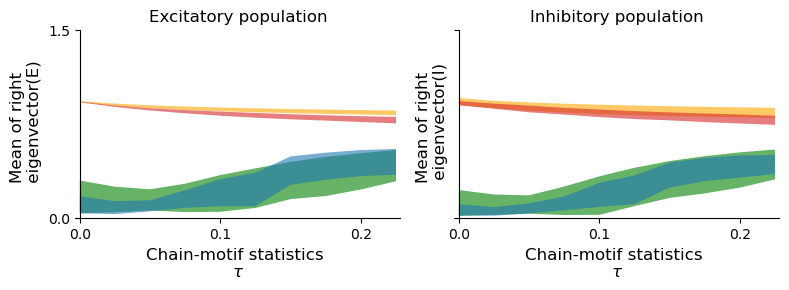

In [17]:
'''### plot the mean of the right eigenvectors'''
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),facecolor='orange',alpha=0.6)

ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,0,0],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,0,0],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,0,0],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,0,0],axis=0),facecolor='tab:red',alpha=0.6)
# for i in range(trials):
#     ax[0].scatter(tau_series,mean_reigvec_num_series[i,:,0,0])
#     print(mean_reigvec_num_series[i,:,0,0])
## second rank
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),facecolor='green',alpha=0.6)
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,1,0],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,1,0],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,1,0],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,1,0],axis=0),facecolor='tab:blue',alpha=0.6)

### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
ax[0].set_ylim(-0.01,0.04)
ax[0].set_yticks([0,0.04])
ax[0].set_ylim(-0.,1.5)
ax[0].set_yticks([0,1.5])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),facecolor='orange',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,0,1],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,0,1],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,0,1],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,0,1],axis=0),facecolor='tab:red',alpha=0.6)

## second rank
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),facecolor='green',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,1,1],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,1,1],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,1,1],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,1,1],axis=0),facecolor='tab:blue',alpha=0.6)

### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
# ax[1].set_ylim(-0.01,0.04)
ax[1].set_ylim(-0.0,1.5)
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of right \n eigenvector(I)',fontsize=12)
fig.tight_layout()
plt.show()

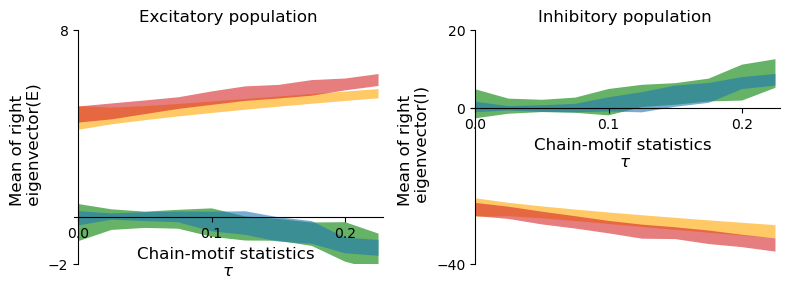

In [20]:
'''### plot the mean of the left eigenvectors'''
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True)
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,0],axis=0),facecolor='orange',alpha=0.6)

ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0),facecolor='tab:red',alpha=0.6)

## second rank
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,0],axis=0),facecolor='green',alpha=0.6)

ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0),facecolor='tab:blue',alpha=0.6)


### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
# ax[0].set_ylim(-0.01,0.04)
# ax[0].set_yticks([0,0.04])
ax[0].set_ylim(-2.0,8)
ax[0].set_yticks([-2.0,8])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,1],axis=0),facecolor='orange',alpha=0.6)

## second rank
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,1],axis=0),facecolor='green',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,0,1]*eigvchn_series_sp[:,:,0],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,0,1]*eigvchn_series_sp[:,:,0],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,0,1]*eigvchn_series_sp[:,:,0],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,0,1]*eigvchn_series_sp[:,:,0],axis=0),facecolor='tab:red',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,1,1]*eigvchn_series_sp[:,:,1],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,1,1]*eigvchn_series_sp[:,:,1],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,1,1]*eigvchn_series_sp[:,:,1],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,1,1]*eigvchn_series_sp[:,:,1],axis=0),facecolor='tab:blue',alpha=0.6)

### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
ax[1].set_ylim(-40,20)
ax[1].set_yticks([-40,0,20])
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of Left \n eigenvector(I)',fontsize=12)
fig.tight_layout()
plt.show()

Compute the theoretical eigenvalue outliers and the spectral radius

In [21]:
### compute the theoretical outliers and the spectral radius
### recording
eigvchn_theo   = np.zeros((ntau,2))
radius_theo_map = np.zeros(ntau)
### print variables and parameters of the adjacency matrix 
print('-------------------')
print('N:',N)
print('g:',g)
print('gamma:',gamma)
print('J:',J)
print('JE,JI:',JE,JI)
print('ge,gi:',ge,gi)
print('c:',c)
print('je,ji:',je,ji)
print('-------------------')


-------------------
N: 1500
g: 6.0
gamma: 0.25
J: 0.012909944487358056
JE,JI: 3.0983866769659336 4.6475800154489
ge,gi: 0.2 1.2000000000000002
c: 0.2
je,ji: 0.012909944487358056 0.07745966692414834
-------------------


In [22]:
'''Theoretical eigenvalue outliers and radius of the bulk'''
ce, ci = c,c
for it, tau in enumerate(tau_series):
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
### theoretical prediction of the eigenvalues

org_k = J*N*(ALPHAE-g*ALPHAI)/2.0

eigvchn_theo[:,0] = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau_series))
eigvchn_theo[:,1] = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau_series))

In [ ]:
# params = {'g':g,
#           'gamma':gamma,
#           'NE':NE,
#           'NI':NI,
#           'J':J,
#           'ce':ce,
#           'ci':ci,
#           'tau_series':tau_series,
#           }
# lst = [eigvchn_series, eigrvec_series, eiglvec_series,
#        eigrvec_series_rec, eiglvec_series_rec,
#         eiglvec0_series, norml0_series, params,
#         leig0mean_series]
# stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
#        "eigrvec_series_rec, eiglvec_series_rec,"
#         "eiglvec0_series, norml0_series, params,"
#         "leig0mean_series"]
# # data = list_to_dict(lst=lst, string=stg)
# data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_AdjGau_4April_PRX_68N1500_normlr_whilecode_used_vecrec.npz"
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/equivalentGaussian/ConnStats_AdjGau_4April_PRX_68N1500_normlr_whilecode_used_vecrec.npz"
# # # data_name = "your data folder/ConnStats_Adjacency_06Dec_16PRX.npz"
# # np.savez(data_name, **data)

#### Generate Fig3

In [ ]:
# ### load the stored data, in particular, extracting variable: eigvchn_series 
# data_name = "---save your data folder---/xxx.npz"
# data = np.load(data_name,allow_pickle=True)

# ### also loading other variables 
# eigvchn_series = data['eigvchn_series']
# eigrvec_series = data['eigrvec_series']
# eiglvec_series = data['eiglvec_series']
# eiglvec0_series = data['eiglvec0_series']
# params = data['params']
# intg_mean_series = data['intg_mean_series']
# leig0mean_series = data['leig0mean_series']


Plot the eigenvalue outlier (numerical, eigvchn_series), as well as the theoretically computed eigenvalue outliers (eigvchn_theo)

In [23]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn = eigvchn_series[ktrial,it,:].copy()

        eigvchn_real = np.real(eigvchn)
        eigvchn_real = np.sort(eigvchn_real)
        eigvchn_real = eigvchn_real[::-1]

        radius = (eigvchn_real[2])
        radius_num_map[ktrial,it] = radius

In [24]:
#### print trial by trial the first two eigenvallues
for ktrial in range(trials):
    eigvchn = eigvchn_series[ktrial,:,:].copy()
    eigvchn_real = (eigvchn)
# ### delete the 17th trial
# eigvchn_series = np.delete(eigvchn_series,17,axis=0) #for ConnStats_Adjacency_12OctDense_.npz
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real = eigvchn_series[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [ 3 25 35 34 23 10 22 26 11  0  2 24 14 28 30 17 18 16 12 31  6 27  4  1
  8 13 19  7 32 29] 30


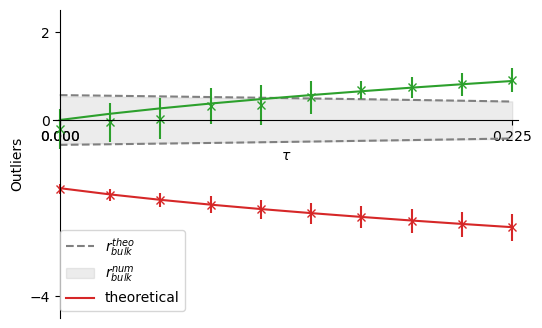

In [26]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(6,4))
### label is r_{bulk}^{num}
ax.plot(tau_series,radius_theo_map,'gray',linestyle='--',label=r'$r_{bulk}^{theo}$')
ax.plot(tau_series,-radius_theo_map,'gray',linestyle='--')
# ax.plot(tau_series,np.mean(radius_num_map,axis=0),'k',label=r'$r_{bulk}^{num}$')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()

ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical')
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green')

### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red',ecolor='tab:red',alpha=1,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=1,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([0,tau_series[-1]//2,tau_series[-1]])
ax.set_ylim([-4.5,2.5])
ax.set_yticks([-4,0,2])
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

In [27]:
''' Theoretical prediction of the intersection between radius and eigenvalue outliers'''
ce, ci = c,c
tau_inter = fsolve(cal_radius_eigv_intersection,0.15,args=(J,g,gamma,ce,ci,N,ALPHAE,ALPHAI))
print('the intersection between radius and eigenvalue outliers:',tau_inter)
print('tau series:',tau_series)

### compute the eigvchn_theo[:,1] and radius_theo_map intersection
idx = np.argmin(np.abs(tau_series-tau_inter))
intersect = np.where(eigvchn_theo[:,1]<=radius_theo_map)[0]
print(intersect[-1])

the intersection between radius and eigenvalue outliers: [0.10711292]
tau series: [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225]
4


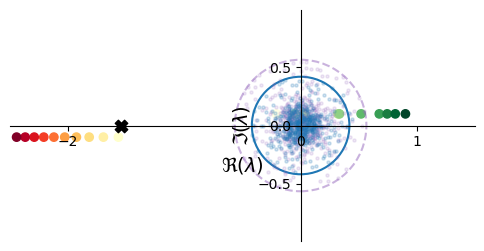

In [33]:
### plot a shifting histogram for the first eigenvalue
fig,ax=plt.subplots(figsize=(6,3))
### plot the mean of the eigenvalues, how it changes with tau_series
### colormap gradiently changes with the tau_series
cm = plt.cm.YlOrRd
### the mean of the first eigenvalue
mean_eigvchn = np.mean(eigvchn_series[idx_eff,:,0].real,axis=0)
sc=ax.scatter(mean_eigvchn,-0.1*np.ones(ntau),c=tau_series,cmap=cm)
### the mean of the second eigenvalue 
cm = plt.cm.YlGn
mean_eigvchn = np.mean(eigvchn_series[idx_eff,:,1].real,axis=0)
sc=ax.scatter(mean_eigvchn,0.1*np.ones(ntau),c=tau_series,cmap=cm)

ax.set_xlabel(r'$\Re(\lambda)$',fontsize=14)
### set double ylabels
ax.set_ylabel(r'$\Im(\lambda)$',fontsize=14)
ax2 = ax.twinx() 
 
color = 'tab:gray'
ax2.tick_params(axis ='y', labelcolor = color) 
ax2.set_yticks([])
ax2.spines['bottom'].set_color('none')
### set other x-axis invisible
ax2.spines['top'].set_color('none')
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_color('none')
# ax.set_title('Eigenvalue spectrum',fontsize=14,fontweight='bold')
### refine the plot 
# ax.set_xlim([-3,2])
# ax.set_ylim([-0.3,0.3])
ax.set_xlim([-2.5,1.5])
ax.set_ylim([-0.3,0.3])

ax.set_aspect('equal')
ax.spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_position(('data',0))
## set the x and y ticks
ax.set_xticks([-2,0,1])
ax.set_yticks([-0.5,0,0.5])
# ### also, plot the theoretical predictions for the first and second eigenvalues
# ax.scatter(eigvchn_theo[:,0].real,np.zeros(ntau),cmap=plt.cm.YlOrRd, c=tau_series, s=50,alpha=1,marker='^')
# ax.scatter(eigvchn_theo[:,1].real,np.zeros(ntau),cmap=plt.cm.YlGn, c=tau_series, s=50,alpha=1,marker='^')

### plot a circle with the radius of the last radius_num_map
ax.add_patch(plt.Circle((0,0),radius_theo_map[-1],color='tab:blue',fill=False,linewidth=1.5,alpha=1))
### plot a circle with the radius of the first radius_num_map
ax.add_patch(plt.Circle((0,0),radius_theo_map[0],color='tab:purple',fill=False,linewidth=1.5,alpha=0.5,linestyle='--'))

ktrial_index = 0
### scatter plot the eigenvalue bulk of this trial
### randomly select 500 points
idx_random = np.random.choice(np.arange(2,N),size=500,replace=False)
ax.scatter(eigvchn_series[ktrial_index,0,idx_random].real,eigvchn_series[ktrial_index,0,idx_random].imag,color='tab:purple', s=5,alpha=0.15)
ax.scatter(eigvchn_series[ktrial_index,-1,idx_random].real,eigvchn_series[ktrial_index,-1,idx_random].imag,color='tab:blue', s=5,alpha=0.2)
### also plot the original eigenvalue outlier: JE-JI, using red color and X marker
ax.scatter(JE-JI,0,color='black',marker='X',s=80,alpha=1)
plt.show()

#### Save all variables and parameters

In [ ]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d

In [ ]:
params = {'g':g,
          'gamma':gamma,
          'NE':NE,
          'NI':NI,
          'J':J,
          'ce':ce,
          'ci':ci,
          'tau_series':tau_series,
          }